# Write and Test fitness_funs_non_dim.py and pop_dyn_non_dim_one_x.py

In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
final_fig_path = "../../Manuscript/Figures/"
from time import time
#from fun_response_funs import *
#from fitness_funs import *
import pandas as pd
import random
import matplotlib as mpl

We use the non-dimensionalized parameters

fitness_funs from fitness_funs.py are in terms of non-dimensionalized params

In [218]:
np.heaviside(0,0.5)

0.5

In [1]:
%%writefile fitness_funs_non_dim.py
import numpy as np
import scipy as sp
# this is written and tested in write_test_pop_dynamics.ipynb

def fun_alpha1(x, α1_of_1, s1, **params):
    ''' capture prob of big prey'''
    θ_1 = - np.log(1/α1_of_1 - 1)/(1-s1)
    return 1/(1 + np.exp(- θ_1 * (x - s1)))
    
def fun_alpha2(x, α2_fun_type, α2_of_1, s2, **params):
    ''' capture prob of small prey'''
    if α2_fun_type == 'constant':
        return α2_of_1
    else:
        θ_2 = - np.log(1/α2_of_1 - 1)/(1-s2)
        return 1/(1 + np.exp(- θ_2 * (x - s2)))

def fun_attack_rate(x, index, α1_of_1, α2_of_1, s1, s2, α2_fun_type,
                    **params):
    '''
    RETIRING THIS BECAUSE IT'S CUMBERSOME...
    
    The attack rate as a function of x
    
    @inputs:
    x: group size, 1,2,3,...
    index: 1 or 2, indicates prey type 1 (big prey) or 2 (small prey)
    α1_of_1: the attack rate of big prey for group size 1
    α2_of_1: the attack rate of small prey for group size 1
    s1: critical group size for big prey, must be >= 2
    s2: critical group size for small prey, must be >= 2
    
    @returns:
    attackrate (a float)

    @example:
    >> fun_attack_rate(1,2,0.05,0.95,2,2,**dict())
    0.9500000000000001
    >> fun_attack_rate(1,1,0.05,0.95,2,2,**dict())
    0.05000000000000001
    
    '''
    if index == 1:
        θ_1 = - np.log(1/α1_of_1 - 1)/(1-s1)
        return 1/(1 + np.exp(- θ_1 * (x - s1)))
    elif index == 2:
        if α2_fun_type == 'constant':
            return α2_of_1
        else:
            θ_2 = - np.log(1/α2_of_1 - 1)/(1-s2)
            return 1/(1 + np.exp(- θ_2 * (x - s2)))

def fun_Y1(x,N1,N2,**params):
    return fun_response_non_dim(x,N1,N2,1,**params)
def fun_Y2(x,N1,N2,**params):
    return fun_response_non_dim(x,N1,N2,2,**params)
def fun_response_non_dim(x, N1, N2, index, H1, H2, **params):
    '''
    non-dimensionalized functional response to prey as a function of predator group size (x) and 
    (non-dimensionalized prey population sizes (N1, N2)
    
    @inputs:
    x - pred group size
    N1, N2 - non-dim big prey and small prey pop sizes, respec
    index - 1 (big prey) or 2 (small prey)
    H1, H2 - non-dimensionalized handling times of big prey, small prey, respec
    params: a dictionary of other parameters, that at least must include 
                α1_of_1, α2_of_1, s1, s2

    @returns
    functional response for prey type <index> (a float)

    @examples
    >>fun_response_non_dim(x=1,N1=0.8,N2=0.8,index=1,a=1,H1=5,H2=5, 
                    **dict(α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 2) )
    0.008000000000000002
    '''
    
    α2 = fun_alpha2(x,**params)
    α1 = fun_alpha1(x,**params)
    if index == 1:
        numerator = α1*N1
    elif index == 2:
        numerator = α2*N2
    denominator = 1 + α1*H1*N1 + α2*H2*N2
    return numerator/denominator
def yield_from_prey_non_dim(x,N1,N2,β1, β2, **params):
    '''
    this is \tilde{pi} in the model, which is pi/(g1 + g2 + delta)
    @inputs:
    x - pred group size
    N1, N2 - big prey, small prey non-dim'ed pop size
    β1, β2 - prey profitability for big prey, small prey, respec
    '''
    tilde_π = β1 * fun_response_non_dim(x, N1, N2, 1,**params) \
                          + β2 * fun_response_non_dim(x, N1, N2, 2, **params)
    return tilde_π
def per_capita_fitness_from_prey_non_dim(x, N1, N2, β1, β2, **params):
    '''
    This is \tilde{w} in the model
    @inputs:
    x - pred group size
    N1, N2 - big prey, small prey non-dim'ed pop size
    β1, β2 - prey profitability for big prey, small prey, respec
    '''
    w_per_capita = (1/x)*(β1 * fun_response_non_dim(x, N1, N2, 1,**params) \
                          + β2 * fun_response_non_dim(x, N1, N2, 2, **params))
    return w_per_capita
    
def fitness_from_prey_non_dim(x, N1, N2, r, γ,**params):
    '''
    portion of inclusive fitness from each prey type, stored in an array, after potentially unequal sharing
    @inputs:
    x - pred group size
    N1, N2 - big prey, small prey non-dim pop size
    r - relatedness between group members
    γ - extent of reproductive skew (portion of subordinate's food donated to dominant)
    params - dictionary of other parameters

    @returns:
    np.array([<inclusive fitness from big prey>, <inclusive fitness from small prey>])
    (so the rows correspond to prey types
    '''
    # set portion size, need to account for x being an array

    w_per_capita = per_capita_fitness_from_prey_non_dim(x, N1, N2, **params)
    try:
        if x > 1:
            repro_exchange = (1-γ)*(1-r) + r*x
            return w_per_capita * repro_exchange
        else:
            return w_per_capita
    except ValueError:
        repro_exchange = np.ones(np.shape(x))
        repro_exchange[x>1] = (1-γ)*(1-r) + r*x[x>1]
        return  w_per_capita * repro_exchange


Overwriting fitness_funs_non_dim.py


In [3]:
%%writefile pop_dyn_non_dim_one_x.py
import numpy as np
import scipy as sp
from fitness_funs_non_dim import *

#from fun_response_funs import *

def pop_model_one_grp_size_x_constant(t, initialstate, x, params):
    P, N1, N2= initialstate
    dPdT = dPdT_one_grp_size(P, N1, N2, x, **params)
    dN1dT = dN1dT_one_grp_size(P, N1, N2, x, **params)
    dN2dT = dN2dT_one_grp_size(P, N1, N2, x, **params)
    return [dPdT, dN1dT, dN2dT]
    
def full_system_one_grp(initialstate, x, params):
    ''' need this for finding roots'''
    t=0
    return pop_model_one_grp_size_x_constant(t, initialstate, x, params)


    
def dPdT_one_grp_size(P, N1, N2, x, η1, η2, β1, β2, **params):
    '''
    the equation for dPdT, the change in predator population size versus time, 
    non-dimensionalized. All preditors in groups of the same size

    @inputs
    P, N1, N2 - nondimensionalized predator, big prey, and small prey pop sizes
    x - the group size of predators
    params - dic of params: η1, η2, A1, β1, β2, H1, H2, α1_of_1, α2_of_1, s1, s2,
    '''
    Y1 = fun_Y1(x,N1,N2,**params)
    Y2 = fun_Y2(x,N1,N2,**params)
    F_of_x = P/x
    td = 1 - η1 - η2

    return F_of_x * (β1 * Y1 + β2 * Y2) - td*P
    
def dN1dT_one_grp_size(P, N1, N2, x, η1, A1, **params):
    Y1 = fun_Y1(x,N1,N2,**params)
    F_of_x = P/x
    return η1*N1*(1-N1) - A1 * F_of_x * Y1


def dN2dT_one_grp_size(P, N1, N2, x, η2, A1, **params):
    Y2 = fun_Y2(x,N1,N2,**params)
    F_of_x = P/x
    A2 = 1 - A1
    return η2*N2*(1-N2) - A2 * F_of_x * Y2   




Overwriting pop_dyn_non_dim_one_x.py


In [3]:
def make_id_params(η1, η2, A1, β1, β2, H1, H2, s1, s2, α2_fun_type,**params):
    string = '%d%d%d%d%d%d%d%d%d'%(η1*10, η2*10, A1*10, β1, β2, H1, H2, s1, s2)
    string = string + '_alpha2' + α2_fun_type
    return string
def print_param_caption(η1, η2, A1, β1, β2, H1, H2, α1_of_1, α2_of_1, 
                        s1, s2, α2_fun_type,**params):
    caption = 'The parameters are '
    caption += f'$\\eta_1 = {η1}, \\eta_2 = {η2}, '
    caption += f'A_1 = {A1}, \\beta_1 = {β1}, \\beta_2 = {β2}, '
    caption += f'H_1 = {H1}, H_2 = {H2}, ' 
    if α2_fun_type == 'constant':
        caption += f'\\alpha_1(1) = {α1_of_1}, s_1 ={s1}$, '
        caption += f'and $\\alpha_2(x) = {α2_of_1}$ is constant.'
    else:
        caption += f'\\alpha_1(1) = {α1_of_1}, \\alpha_2(1) = {α2_of_1}, '
        caption += f's_1 = {s1}$, and $s_2 = {s2}$' 
    
    print(caption)
def print_initial_states_caption(initialstates, colors):
    caption =""
    for initialstate, color in zip(initialstates, colors):
        P,N1,N2,x = initialstate
        caption += f"$(P={P}, N_1 = {N1}, N_2 = {N2}, x = {x})$ ({color}), "
    caption = caption[:-2]
    caption += "."
    print(caption)
#    The initial states are 

In [440]:
params_reg = dict(η1 = 0.2, η2 = 0.7, A1 = 0.5, β1 = 7, β2 = 2, H1=0, H2=0, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                 Tx = 1, r = 0, γ = 0)
params_reg_id = params_reg

In [441]:
print_param_caption(**params_reg.copy())

The parameters are $\eta_1 = 0.2, \eta_2 = 0.7, A_1 = 0.5, \beta_1 = 7, \beta_2 = 2, H_1 = 0, H_2 = 0, \alpha_1(1) = 0.05, s_1 =2$, and $\alpha_2(x) = 0.95$ is constant.


In [247]:
initialstate1 = [0.2, 1, 1, 1]
initialstate2 = [8,0.5,0.2, 1]
initialstate3 = [12, 0.1, 0.3, 1]
initialstates = [initialstate1, initialstate2, initialstate3]
colors = ['black', 'blue', 'red']
print_initial_states_caption(initialstates, colors)

$(P=0.2, N_1 = 1, N_2 = 1, x = 1)$ (black), $(P=8, N_1 = 0.5, N_2 = 0.2, x = 1)$ (blue), $(P=12, N_1 = 0.1, N_2 = 0.3, x = 1)$ (red).


# Apparent Competition

In [11]:
np.log(1) - np.log(1e-1000 * 1e1000)

nan

In [11]:
dN1dT_one_grp_size?

Signature: dN1dT_one_grp_size(P, N1, N2, x, η1, A1, **params)
Docstring: <no docstring>
File:      /var/folders/tp/jbfyy0qd62910dnqkytn6dqc0000gn/T/ipykernel_57139/247144008.py
Type:      function

In [53]:
params = params_reg.copy()
params['η1'] = 0.5
params['η2'] = 0.3

N2 = 1
P = 10
x = 10
#inputs = [P, N1, N2, x]
dN2dN1 = [ dN2dT_one_grp_size(P, N1, N2, x, **params.copy())/\
          dN1dT_one_grp_size(P, N1/100, N2, x, **params.copy()) for N1 in range(1,100)]

In [117]:
def plot_apparent_comp_N1_vs_N2(fig, ax, x,cbar,**params):
    num = 500
    N1 = np.linspace(1e-10,1-1e-10,num)
    N2 = N1.copy()
    
    # check not dividing by zero:
    A1 = params['A1']
    α1_of_x = fun_alpha1(x,**params.copy())
    η1 = params['η1']
    N1_asymptote = 1 - (P/x)*A1*α1_of_x/η1
    N1 = N1[N1 != N1_asymptote]
    N2 = N2[N1 != N1_asymptote]
    num = len(N2)

    N1_mat, N2_mat = np.meshgrid(N1, N2)
    dN2dN1 = dN2dT_one_grp_size(P, N1_mat, N2_mat, x, **params.copy()) / \
            dN1dT_one_grp_size(P, N1_mat, N2_mat, x, **params.copy())
    competition_facilitation = dN2dN1 > 0
    colors = [ 'white', 'black' ]
    bounds = [-0.5, 0.5, 1.5]
    ticks = [0., 1.]
    cb_tick_labs = ['Competition','Facilitation']

    cmap   = mpl.colors.ListedColormap( colors )
    norm = mpl.colors.BoundaryNorm(bounds,cmap.N)
    
    p = ax.pcolormesh(N1_mat,N2_mat,competition_facilitation[:-1,:-1], cmap=cmap, norm=norm)
    ax.set_xlim([-0.001,1.001])
    ax.set_ylim([-0.001,1.001])
    text_fs = 20
    ax.set_xlabel(r'$N_1$', fontsize = text_fs)
    ax.set_ylabel(r'$N_2$', fontsize = text_fs)
    #ax.set_title(title, fontsize = text_fs)
    
    if cbar: # show colorbar
        figc, axc = plt.subplots(1,1, figsize = (1,10))
        cb = figc.colorbar(p,boundaries = bounds,
                    aspect = 20, ticks = ticks, cax= axc)
        cb.set_ticklabels(cb_tick_labs)
        cb.ax.tick_params(labelsize=text_fs)
        
        return fig, ax, figc
    else:
        return fig, ax
#p = ax.pcolormesh(x_mat,y_mat,typemat[:-1,:-1], cmap=cmap, norm=norm)

In [204]:
def area_apparent_competition_noH(P, x, A1, η1, η2,α2_fun_type, **params):
    
    α1 = fun_alpha1(x,**params)
    α2 = fun_alpha2(x,**params)
    A2 = 1 - A1
    c1 = A1*α1/η1
    c2 = A2*α2/η2
    N1t = 1 - c1*P/x
    N2t = 1 - c2*P/x

    mask_both_pos = (N1t > 0) & (N2t > 0)
    area_both_pos = N1t * (1 - N2t) + (1 - N1t) * N2t

    mask_N1t_neg = (N1t < 0) & (N2t > 0)
    area_N1t_neg = N2t

    mask_N2t_neg = (N1t > 0) & (N2t < 0)
    area_N2t_neg = N1t

    area_vec = np.zeros(area_both_pos.shape)
    area_vec[mask_both_pos] = area_both_pos[mask_both_pos]
    area_vec[mask_N1t_neg] = area_N1t_neg[mask_N1t_neg]
    area_vec[mask_N2t_neg] = area_N2t_neg[mask_N2t_neg]

    return area_vec, N1t, N2t

Text(0, 0.5, 'Portion $\\{N_1,N_2\\}$ with\nApparent Competition')

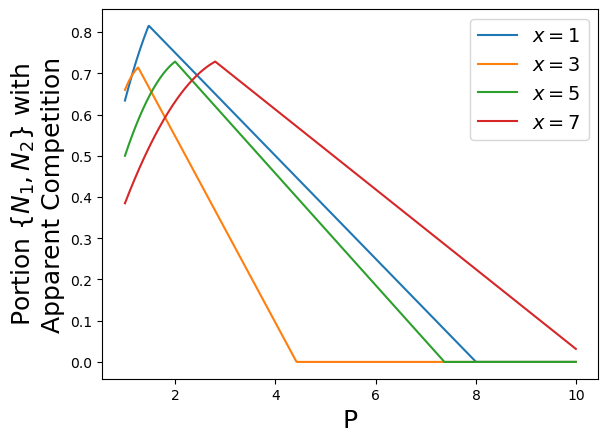

In [205]:
xvec = [1,3,5,7]
pvec = np.arange(1,10,0.01)
linelabel = '$x = $%d'

for x in xvec:
    area, N1t, N2t = area_apparent_competition_noH(pvec, x, **params_reg.copy())
    plt.plot(pvec,area, label = linelabel %x)
plt.legend(fontsize = 14)
fs = 18
plt.xlabel('P', fontsize = fs)
plt.ylabel(r'Portion $\{N_1,N_2\}$ with' + '\nApparent Competition', fontsize = fs)


In [206]:
params_reg

{'η1': 0.2,
 'η2': 0.7,
 'A1': 0.5,
 'β1': 7,
 'β2': 2,
 'H1': 0,
 'H2': 0,
 'α1_of_1': 0.05,
 'α2_of_1': 0.95,
 's1': 2,
 's2': 2,
 'α2_fun_type': 'constant'}

Text(0, 0.5, 'Portion $\\{N_1,N_2\\}$ with\nApparent Competition')

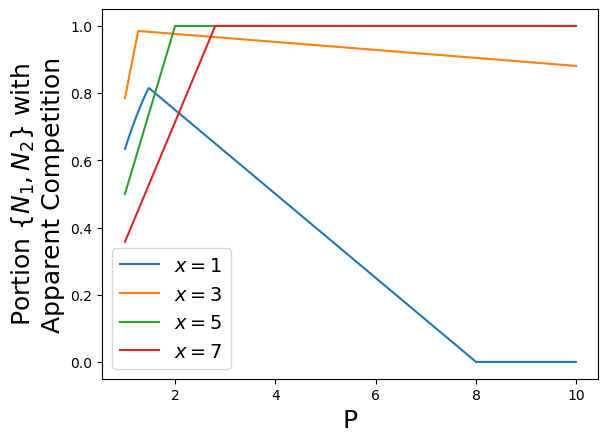

In [208]:
params = params_reg.copy()
params['α2_fun_type'] = 'sigmoid'
xvec = [1,3,5,7]
pvec = np.arange(1,10,0.01)
linelabel = '$x = $%d'

for x in xvec:
    area, N1t, N2t = area_apparent_competition_noH(pvec, x, **params.copy())
    plt.plot(pvec,area, label = linelabel %x)
plt.legend(fontsize = 14)
fs = 18
plt.xlabel('P', fontsize = fs)
plt.ylabel(r'Portion $\{N_1,N_2\}$ with' + '\nApparent Competition', fontsize = fs)

In [ ]:
xvec = [1,3,5,7]
pvec = np.arange(1,10,0.01)
linelabel = '$x = $%d'

for x in xvec:
    area, N1t, N2t = area_apparent_competition_noH(pvec, x, **params_reg.copy())
    plt.plot(pvec,area, label = linelabel %x)
plt.legend(fontsize = 14)
fs = 18
plt.xlabel('P', fontsize = fs)
plt.ylabel(r'Portion $\{N_1,N_2\}$ with' + '\nApparent Competition', fontsize = fs)

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (5,5))


275720022_alpha2constant
apparent_competition_1_275720022_alpha2constant.png
apparent_competition_5_275720022_alpha2constant.png
apparent_competition_cbar_5_275720022_alpha2constant.png


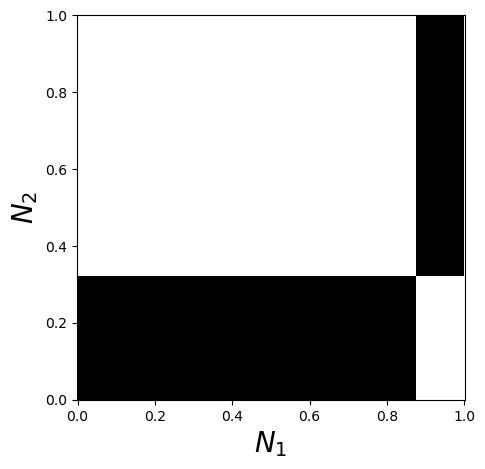

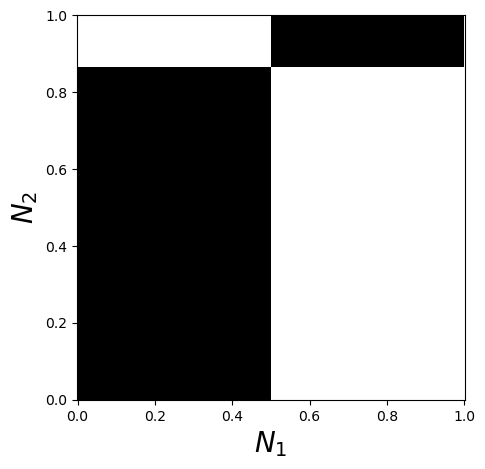

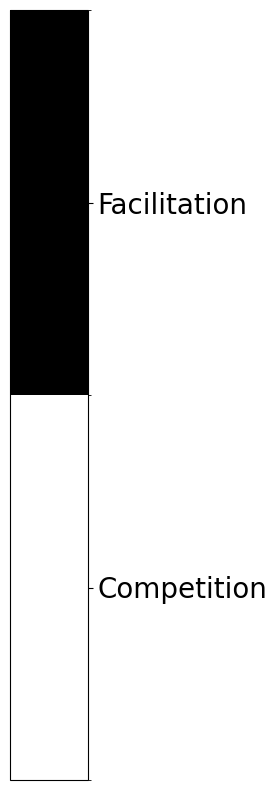

In [123]:
fig, ax = plt.subplots(1,1,figsize=(5, 5))
params_id = make_id_params(**params_reg.copy())
print(params_id)

x=1
cbar=False
fig, ax = plot_apparent_comp_N1_vs_N2(fig, ax, x,cbar,**params)
figname = 'apparent_competition_' + str(x) +'_'+params_id + '.png'
print(figname)
fig.savefig(final_fig_path + \
                    figname
                      , bbox_inches = 'tight')

fig, ax, = plt.subplots(1,1,figsize=(5, 5))
x=5
cbar=True
fig, ax,figc = plot_apparent_comp_N1_vs_N2(fig, ax, x,cbar,**params)
figname = 'apparent_competition_' + str(x) +'_'+params_id + '.png'
print(figname)
fig.savefig(final_fig_path + \
                    figname
                      , bbox_inches = 'tight')

cb_figname = 'apparent_competition_cbar_' + str(x) +'_'+params_id + '.png'
print(cb_figname)
fig.savefig(final_fig_path + figname, bbox_inches = 'tight')

(-0.001, 1.001)

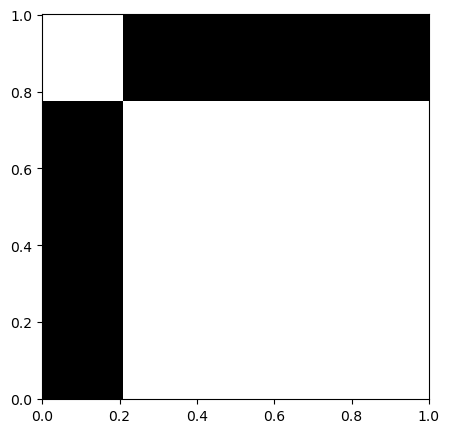

In [101]:
params = params_reg.copy()
P=1
x=3
figwidth = 5
figheight = 5

num = 500
N1 = np.linspace(1e-10,1-1e-10,num)
N2 = N1.copy()


# check not dividing by zero:
A1 = params['A1']
α1_of_x = fun_alpha1(x,**params.copy())
η1 = params['η1']
N1_asymptote = 1 - (P/x)*A1*α1_of_x/η1
N1 = N1[N1 != N1_asymptote]
N2 = N2[N1 != N1_asymptote]
num = len(N2)

N1_mat, N2_mat = np.meshgrid(N1, N2)
dN2dN1 = dN2dT_one_grp_size(P, N1_mat, N2_mat, x, **params.copy()) / \
            dN1dT_one_grp_size(P, N1_mat, N2_mat, x, **params.copy())
competition_facilitation = dN2dN1 > 0


fig, ax = plt.subplots(1,1,figsize=(figwidth, figwidth))

colors = [ 'white', 'black' ]
bounds = [-0.5, 0.5, 1.5]
ticks = [1., 2.]
cb_tick_labs = ['Competition','Facilitation']

cmap   = mpl.colors.ListedColormap( colors )
norm = mpl.colors.BoundaryNorm(bounds,cmap.N)

p = ax.pcolormesh(N1_mat,N2_mat,competition_facilitation[:-1,:-1], cmap=cmap, norm=norm)
ax.set_xlim([-0.001,1.001])
ax.set_ylim([-0.001,1.001])

In [91]:
competition_facilitation

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

# Alpha 2 constant

In [321]:
out

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.090e-03 ...  9.997e+03  1.000e+04]
        y: [[ 1.200e+01  1.200e+01 ...  2.062e+00  2.066e+00]
            [ 1.000e-01  9.993e-02 ...  6.117e-02  6.090e-02]
            [ 3.000e-01  2.908e-01 ...  7.438e-01  7.430e-01]
            [ 1.000e+00  1.000e+00 ...  5.447e+00  5.447e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3798
     njev: 91
      nlu: 91

## For group dynamics slow (T = 1)

In [311]:
P, N1, N2, x = out.y

In [332]:
initialstates

[[0.2, 1, 1, 1], [8, 0.5, 0.2, 1], [12, 0.1, 0.3, 1]]

In [397]:
out

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.090e-03 ...  5.588e+04  1.000e+05]
        y: [[ 1.200e+01  1.204e+01 ...  5.972e+00  5.972e+00]
            [ 1.000e-01  9.993e-02 ... -6.355e-33  2.823e-30]
            [ 3.000e-01  2.908e-01 ...  3.084e-01  3.084e-01]
            [ 1.000e+00  1.000e+00 ...  5.860e+00  5.860e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 319
     njev: 6
      nlu: 6

True
True
True


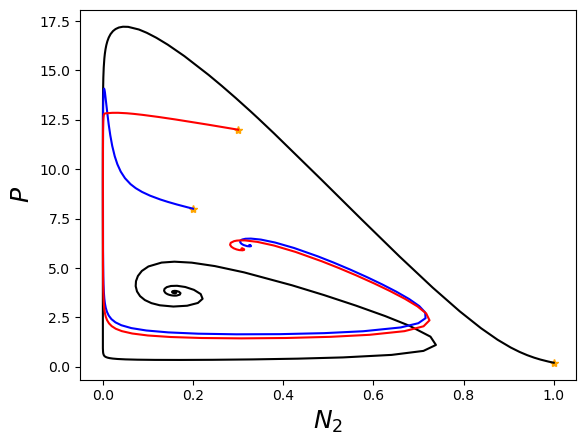

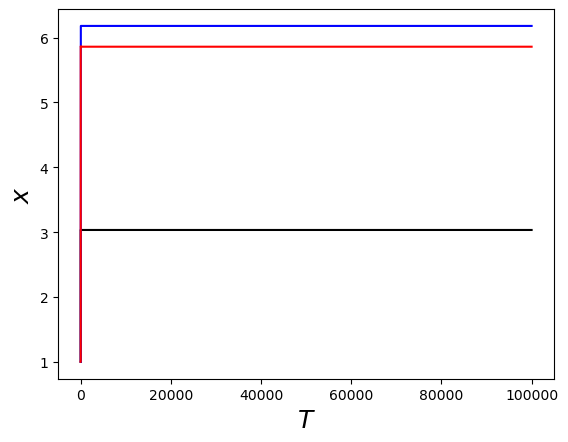

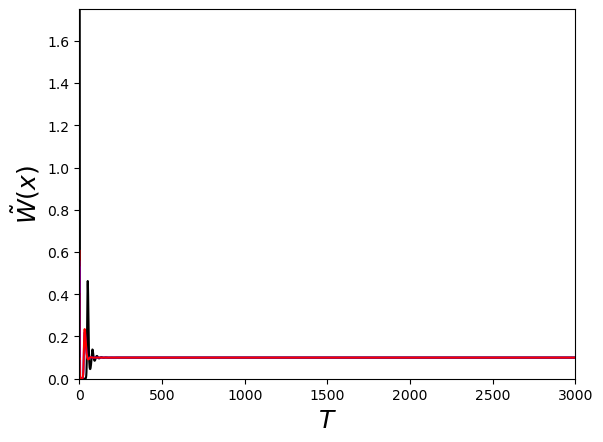

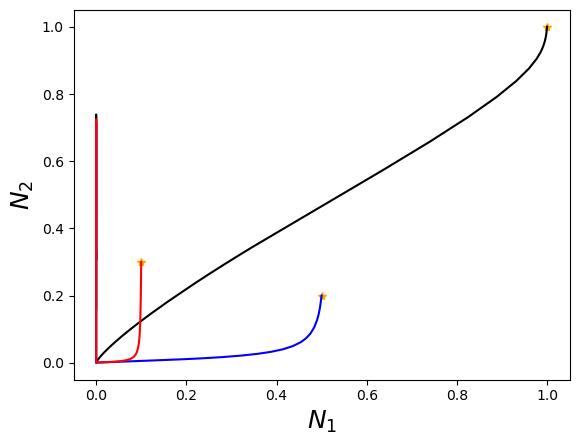

In [401]:
t_f = 100000
fig1, ax1  = plt.subplots(1,1) # P vs N1
fig2, ax2 = plt.subplots(1,1) # x vs T
fig3, ax3 = plt.subplots(1,1) # x vs T
fig4, ax4 = plt.subplots(1,1) # x vs T

f2 = 20
equilibriums = []

for i,initialstate in enumerate(initialstates):
    out = solve_ivp(pop_model_one_grp_size, [0, t_f], initialstate, 
                args=[params_reg.copy()], method = 'LSODA')
    
    ax1.plot(initialstate[2], initialstate[0], marker = '*', c = 'orange')
    P,N1,N2,x = out.y
    ax1.plot(N2,P,colors[i])
    ax1.set_xlabel(r'$N_2$', fontsize = fs)
    ax1.set_ylabel(r'$P$', fontsize = fs)

    

    #ax2.plot(initialstate[1], initialstate[3], marker = '*', c = 'orange')
    ax2.plot(out.t, x, colors[i])
    print(out.success)
    #ax2.set_xlim([0,20])
    equilibrium = out.y[:,-1]
    equilibriums.append(equilibrium)
    ax2.set_xlabel(r'$T$', fontsize = fs)
    ax2.set_ylabel(r'$x$', fontsize = fs)

    fitness = per_capita_fitness_from_prey_non_dim(x, N1, N2, **params_reg.copy())
    ax3.plot(out.t, fitness, colors[i])
    ax3.set_xlim(0,3000)
    ax3.set_ylim(0,1.75)
    ax3.set_xlabel(r'$T$', fontsize = fs)
    ax3.set_ylabel(r'$\tilde{W}(x)$', fontsize = fs)

    ax4.plot(initialstate[1], initialstate[2], marker = '*', c = 'orange')
    ax4.plot(N1, N2, colors[i])
    ax4.set_xlabel(r'$N_1$', fontsize = fs)
    ax4.set_ylabel(r'$N_2$', fontsize = fs)
    # now plot fitness
    

In [402]:
equilibriums

[array([3.75749624e+00, 1.94540387e-51, 1.59700564e-01, 3.03431072e+00]),
 array([ 6.14520239e+00, -6.88434465e-36,  3.25275971e-01,  6.18024346e+00]),
 array([5.97217664e+00, 2.82289527e-30, 3.08406740e-01, 5.85972807e+00])]

In [418]:
def equilibrium_allx_coexist(x, η1, η2, A1, α2_fun_type, **params):
    A2 = 1 - A1
    α1 = fun_alpha1(x,**params)
    if α2_fun_type == 'constant':
        α2 = params['α2_of_1']
    elif α2_fun_type == 'sigmoid':
        α2 = fun_alpha2(x,**params)
    print(α1)
    td = 1 - η1 - η2

    P = (x*(β1*α1 + β2*α2) - td*x**2)/( (A1*β1*α1**2)/η1 + (A2*β2*α2**2)/η2 )
    N2 = 1 - (P/x)*A2*α2/η2
    N1 = 1 - (P/x)*A1*α1/η1
    return P, N1, N2
def equilibrium_allx_no_big(x, η2, A1, α2_fun_type, **params):
    A2 = 1 - A1
    if α2_fun_type == 'constant':
        α2 = params['α2_of_1']
    elif α2_fun_type == 'sigmoid':
        α2 = fun_alpha2(x,**params)
    td = 1 - η1 - η2
    N1 = 0
    N2 = td*x/β2*α2
    P = η2*(1- N2)*x / (A2*α2)
    
    return P, N1, N2
def equilibrium_allx_no_small(x, η1, A1, α2_fun_type, **params):
    α1 = fun_alpha1(x,**params)
    td = 1 - η1 - η2
    
    N2 = 0
    N1 = td*x/β1*α1
    P = η1*(1- N1)*x / (A1*α1)
    
    return P, N1, N2

def get_evals(P,N1,N2,x,**params):
    return 1

In [419]:
equilibrium_allx_no_small(1,**params_reg.copy())

(7.959999999999999, 0.005000000000000005, 0)

In [411]:
equilibrium_allx(20, **params_reg.copy())

1.0


(-0.31800113571835315, 1.039750141964794, 1.010789324247587)

In [387]:
print(ans)

(1.6546629732225295, -0.30994152046783596, 0.6257309941520469)


In [394]:
equilibriums

array([[6.22222222e+00, 2.22222222e-01, 9.52911730e-07],
       [1.21883657e+00, 3.50877193e-02, 7.24584263e-01],
       [3.55555556e+00, 1.11111111e-01, 7.59123121e-01],
       [6.22222222e+00, 2.22222222e-01, 7.89768285e-01]])

In [430]:
initialstates

[[0.2, 1, 1, 1], [8, 0.5, 0.2, 1], [12, 0.1, 0.3, 1]]

popdyn_all20_275720022_alpha2constant.png
popdyn_all20_275720022_alpha2constant.png
popdyn_all20_275720022_alpha2constant.png
popdyn_all20_275720022_alpha2constant.png


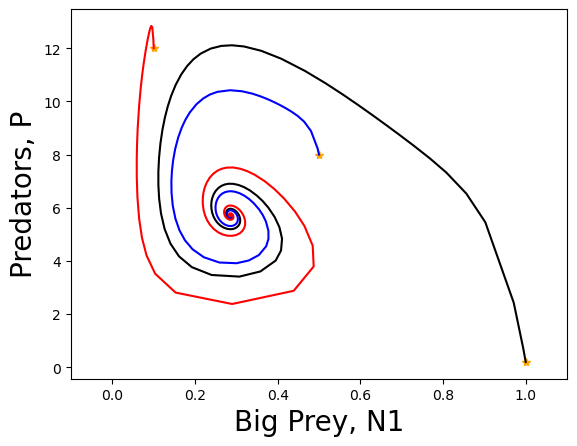

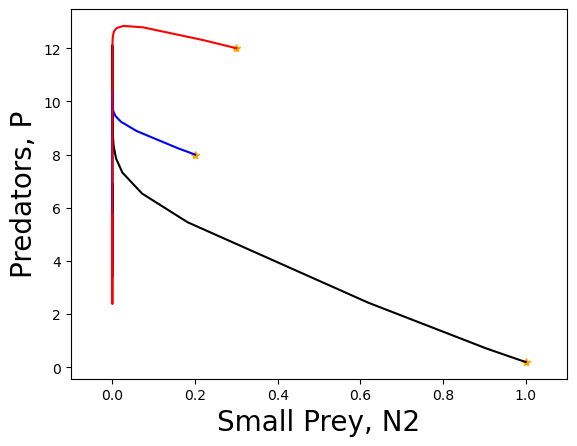

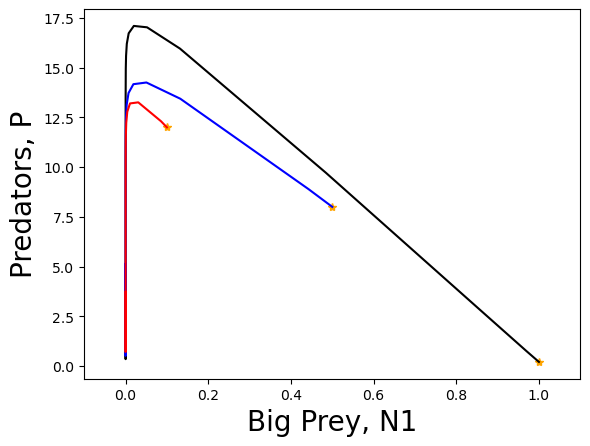

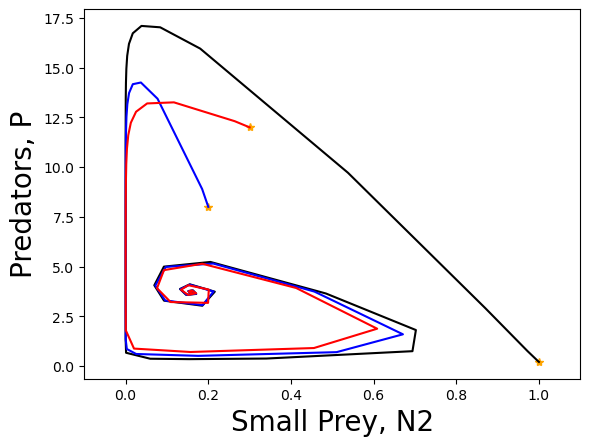

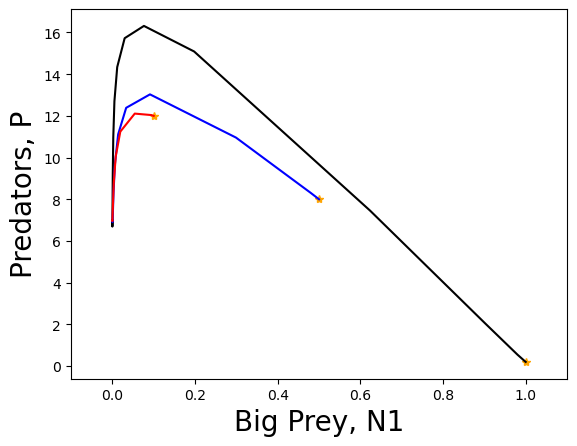

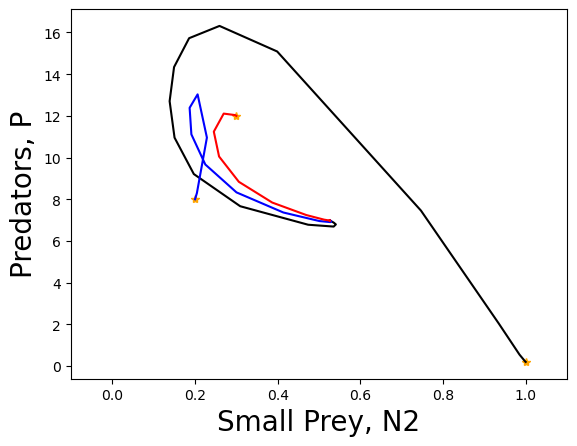

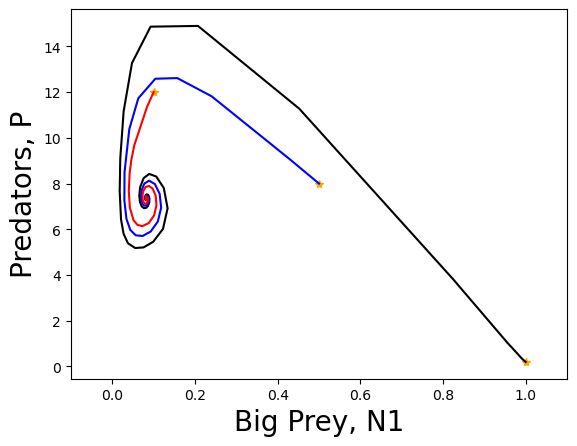

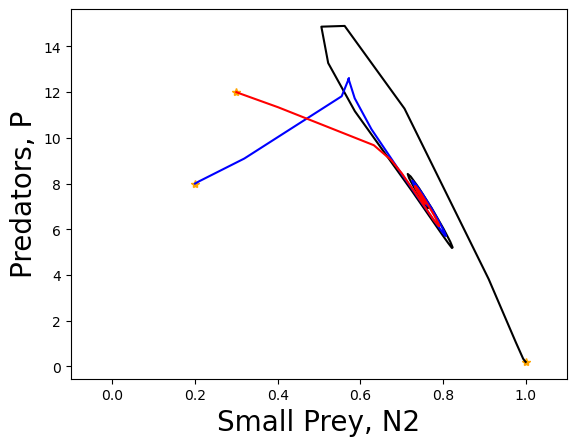

In [427]:
equilibriums = np.zeros((4,3))
for j,x in enumerate([1, 3, 10, 20]):
    t_f = 10000
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    for i,initialstate in enumerate(initialstates):
        out = solve_ivp(pop_model_one_grp_size_x_constant, [0, t_f], initialstate[0:3], 
                    args=(x, params_reg.copy()))
        ax1.plot(initialstate[1], initialstate[0], marker = '*', c = 'orange')
        ax1.plot(out.y[1,:],out.y[0,:],colors[i])

        ax2.plot(initialstate[2], initialstate[0], marker = '*', c = 'orange')
        ax2.plot(out.y[2,:], out.y[0,:], colors[i])
        
    equilibriums[j,:] = out.y[:,-1]
    
    
    for ax in [ax1, ax2]:
        ax.set_xlim([-0.1,1.1])
        ax.set_ylabel('Predators, P', fontsize = 20)
    
    ax1.set_xlabel('Big Prey, N1', fontsize = 20)
    ax2.set_xlabel('Small Prey, N2', fontsize = 20)
    
    params_id = make_id_params(**params_reg.copy())
    figname1 = 'popdyn_all' + str(x) +'_'+params_id + '.png'
    print(figname)
    fig1.savefig(final_fig_path + \
                    figname1
                      , bbox_inches = 'tight')
    figname2 = 'popdyn_all' + str(x) +'_'+params_id + '_N2.png'
    fig2.savefig(final_fig_path + \
                    figname2
                      , bbox_inches = 'tight')

popdyn_all20_275720022_alpha2constant.png
popdyn_all20_275720022_alpha2constant.png
popdyn_all20_275720022_alpha2constant.png
popdyn_all20_275720022_alpha2constant.png


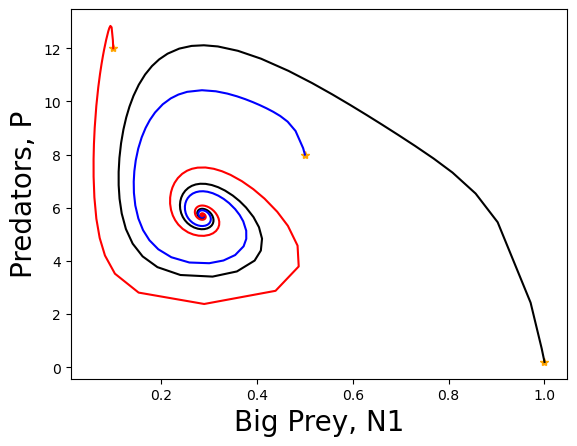

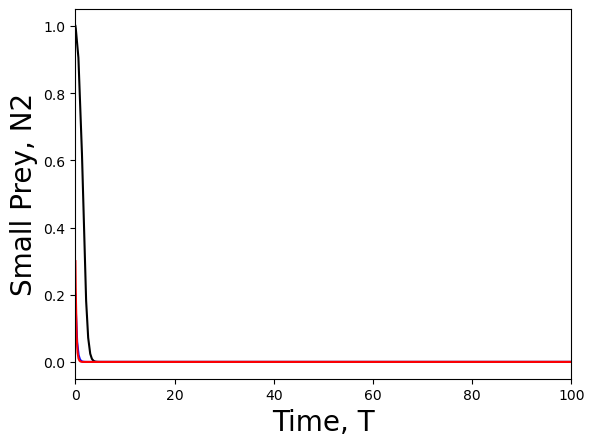

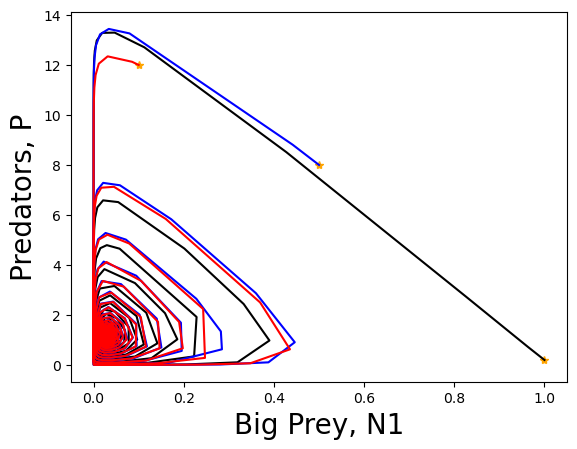

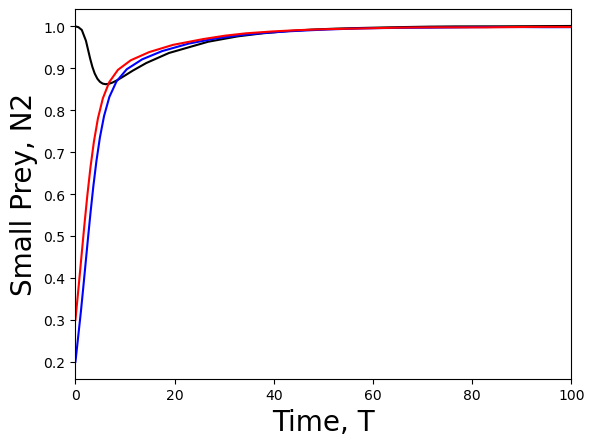

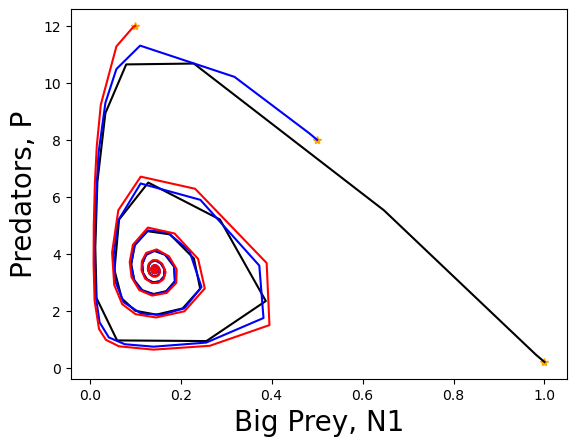

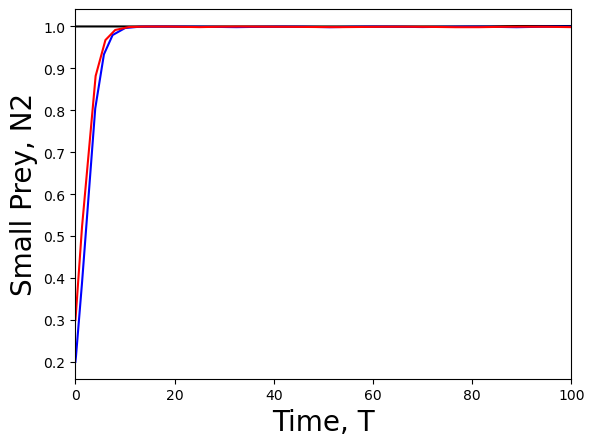

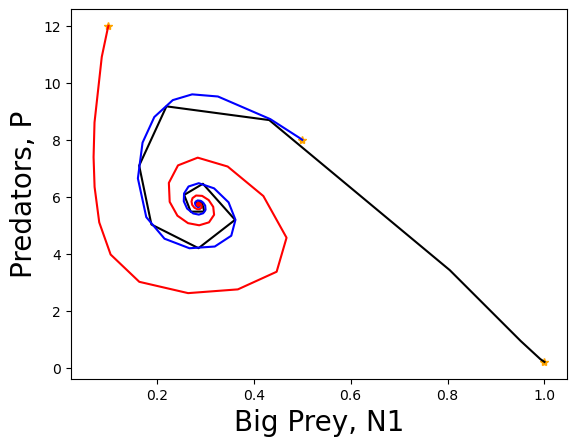

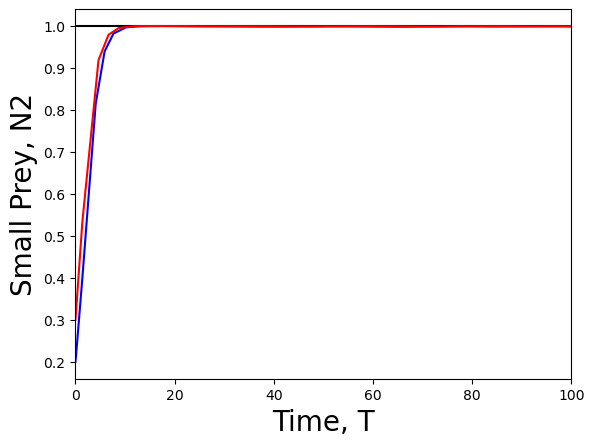

In [442]:
params = params_reg.copy()
params['α2_fun_type'] = 'sigmoid'

equilibriums = np.zeros((4,3))
for j,x in enumerate([1, 3, 10, 20]):
    t_f = 10000
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    for i,initialstate in enumerate(initialstates):
        out = solve_ivp(pop_model_one_grp_size_x_constant, [0, t_f], initialstate[0:3], 
                    args=(x, params.copy()))
        ax1.plot(initialstate[1], initialstate[0], marker = '*', c = 'orange')
        ax1.plot(out.y[1,:],out.y[0,:],colors[i])

        #ax2.plot(initialstate[2], initialstate[0], marker = '*', c = 'orange')
        ax2.plot(out.t, out.y[2,:], colors[i])
        
    equilibriums[j,:] = out.y[:,-1]
    
    
    ax1.set_ylabel('Predators, P', fontsize = 20)
    ax1.set_xlabel('Big Prey, N1', fontsize = 20)

    ax2.set_xlim([0,100])
    ax2.set_xlabel('Time, T', fontsize = 20)
    ax2.set_ylabel('Small Prey, N2', fontsize = 20)
    
    params_id = make_id_params(**params.copy())
    figname1 = 'popdyn_all' + str(x) +'_'+params_id + '.png'
    print(figname)
    

In [445]:
equilibrium_allx_coexist(20, **params)

1.0


(-8.000000000000014, 2.0000000000000018, 1.0)

In [443]:
equilibriums

array([[5.71428461e+00, 2.85714282e-01, 2.05273790e-07],
       [1.22484668e+00, 3.02939448e-02, 9.86193148e-01],
       [3.42857143e+00, 1.42857143e-01, 9.98640425e-01],
       [5.71428571e+00, 2.85714286e-01, 9.99571633e-01]])

In [436]:
params

{'η1': 0.2,
 'η2': 0.7,
 'A1': 0.5,
 'β1': 7,
 'β2': 2,
 'H1': 0,
 'H2': 0,
 'α1_of_1': 0.05,
 'α2_of_1': 0.95,
 's1': 2,
 's2': 2,
 'α2_fun_type': 'sigmoid',
 'Tx': 1,
 'r': 0,
 'γ': 0}

In [431]:
equilibriums

array([[5.71428461e+00, 2.85714282e-01, 2.05273790e-07],
       [1.22484668e+00, 3.02939448e-02, 9.86193148e-01],
       [3.42857143e+00, 1.42857143e-01, 9.98640425e-01],
       [5.71428571e+00, 2.85714286e-01, 9.99571633e-01]])

In [ ]:
fig1.savefig(final_fig_path + \
                    figname1
                      , bbox_inches = 'tight')
    figname2 = 'popdyn_all' + str(x) +'_'+params_id + '_N2.png'
fig2.savefig(final_fig_path + \
                    figname2
                      , bbox_inches = 'tight')